<b> Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#Matplot to graph
from matplotlib import pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [2]:
df = pd.read_csv("/Users/kyleoddson/coursera/coursera/toronto2.csv")

In [3]:
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [4]:
df.groupby("Borough").count()

,PostalCode,Neighborhood,Latitude,Longitude
Borough,,,,
Central Toronto,9,9,9,9
Downtown Toronto,19,19,19,19
East Toronto,5,5,5,5
East York,5,5,5,5
Etobicoke,12,12,12,12
Mississauga,1,1,1,1
North York,24,24,24,24
Scarborough,17,17,17,17
West Toronto,6,6,6,6


<b> Only going to work with the "... Toronto" boroughs

In [5]:
Tor = df[df["Borough"].isin(["Central Toronto", "Downtown Toronto", "East Toronto"])]

In [6]:
Tor.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [7]:
Tor.shape

(33, 5)

In [8]:
Tor.reset_index(inplace=True, drop=True)

In [9]:
Tor.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Tor['Borough'].unique()),
        Tor.shape[0]
    )
)

The dataframe has 3 boroughs and 33 neighborhoods.


<b> Use geopy library to get the latitude and longitude values of Toronto.
Define an instance of the geocoder. We will name our agent my_toronto.

In [11]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="my_toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


<b> Create a map of Toronto with neighborhoods superimposed on top

In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(Tor['Latitude'], Tor['Longitude'], Tor['Borough'], Tor['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<b> Private Foursquare credentials will be read from a file

In [13]:
foursq = pd.read_csv('/Users/kyleoddson/coursera/coursera/foursqu.csv')
CLIENT_ID = foursq.columns[0]
CLIENT_SECRET = foursq.columns[1]
VERSION = foursq.columns[2]

<b> Create a function to get venues for all the neighborhoods in Toronto

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<b> Apply this function to all the neighborhoods and create a new dataframe called toronto_venues

In [15]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=Tor['Neighborhood'],
                                   latitudes=Tor['Latitude'],
                                   longitudes=Tor['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
North Toronto West
The Annex, North Midtown, Yorkville
Davisville
University of Toronto, Harbord
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley
Business reply mail Processing CentrE


<b> Check size of resulting dataframe

In [16]:
print(toronto_venues.shape)
toronto_venues.head()

(1465, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


<b> Check how many venues returned for each neighborhood

In [17]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
Business reply mail Processing CentrE,17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,65,65,65,65,65,65
Christie,18,18,18,18,18,18
Church and Wellesley,72,72,72,72,72,72
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34
Davisville North,7,7,7,7,7,7


<b>Analyze each neighborhood

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 


In [19]:
# find which column contains Neighborhoods
for i, col in enumerate(list(toronto_onehot)):
    if col == "Neighborhood":
        print(i)

154


In [20]:
# Move Neighborhood column to first column
fixed_columns = [toronto_onehot.columns[154]] + list(toronto_onehot.columns[:154]) + list(toronto_onehot.columns[155:])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [21]:
toronto_onehot.shape

(1465, 222)

<b> Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.035088,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.035088,0.000000,0.000000,0.017544,0.0000,0.000000,0.0000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.017544,0.052632,0.070175,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.017544,0.000000,0.017544,0.000000,0.000000,0.000000,0.000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.00,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.017544,0.017544,0.000000,0.000000,0.00

<b> Print each neighborhood along with the top 5 most common venues

In [23]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print(hood+": ")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

Berczy Park: 
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2  Italian Restaurant  0.04
3                Café  0.04
4         Cheese Shop  0.04


Business reply mail Processing CentrE: 
              venue  freq
0        Smoke Shop  0.06
1     Garden Center  0.06
2       Pizza Place  0.06
3        Comic Shop  0.06
4  Recording Studio  0.06


CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport: 
                venue  freq
0      Airport Lounge  0.12
1     Airport Service  0.12
2    Airport Terminal  0.12
3             Airport  0.06
4  Airport Food Court  0.06


Central Bay Street: 
                 venue  freq
0          Coffee Shop  0.20
1                 Café  0.06
2   Italian Restaurant  0.06
3       Sandwich Place  0.05
4  Japanese Restaurant  0.05


Christie: 
           venue  freq
0  Grocery Store  0.22
1           Café  0.17
2           Park  0.11
3          Diner  0.06
4    Candy Store

<b> Build this into a dataframe, first sorting venues in descending order

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<b> Build the dataframe and display top 10 venues for each neighborhood

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Bakery,Italian Restaurant,Cheese Shop,Café,Restaurant,Seafood Restaurant
1,Business reply mail Processing CentrE,Skate Park,Recording Studio,Butcher,Farmers Market,Light Rail Station,Burrito Place,Auto Workshop,Restaurant,Spa,Pizza Place
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Airport,Harbor / Marina,Coffee Shop,Plane,Rental Car Location,Sculpture Garden,Boutique
3,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Japanese Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Fried Chicken Joint,Salad Place,Burger Joint
4,Christie,Grocery Store,Café,Park,Diner,Coffee Shop,Italian Restaurant,Baby Store,Restaurant,Athletics & Sports,Nightclub


<b> Determine the optimal number of clusters (elbow method):

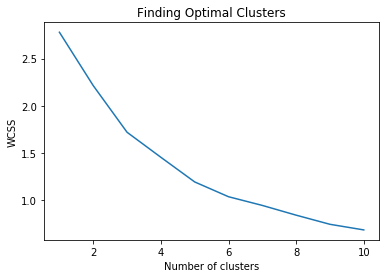

In [26]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

elbow = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300,
                   n_init = 10, random_state = 0)
    kmeans.fit(toronto_grouped_clustering)
    elbow.append(kmeans.inertia_)
plt.plot(range(1,11), elbow)
plt.title('Finding Optimal Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<b> Since there is little change in Within Cluster Sum of Squares (WCSS) for more than 5 clusters, we will use K = 5

In [27]:
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

<b> Create a new dataframe for visualization

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = Tor

# merge toronto_grouped with Tor to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Restaurant,Café,Theater,Mexican Restaurant,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,3,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Music Venue,Beer Bar,Sandwich Place,Burger Joint,Burrito Place,Café
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,Clothing Store,Coffee Shop,Café,Restaurant,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Ramen Restaurant,Bookstore
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,Italian Restaurant,Hotel,Seafood Restaurant,Restaurant,Creperie
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


<b> Visualize the clusters

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<b> Examine the clusters

<b> Cluster 1

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,The Beaches,0,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
18,Forest Hill North & West,0,Bus Line,Jewelry Store,Trail,Sushi Restaurant,Yoga Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


<b> Cluster 2

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]


,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,"Moore Park, Summerhill East",1,Park,Playground,Trail,Summer Camp,Yoga Studio,Dance Studio,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
27,Rosedale,1,Park,Playground,Trail,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


<b> Cluster 3

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]



,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Roselawn,2,Garden,Ice Cream Shop,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


<b> Cluster 4

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]



,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",3,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Restaurant,Café,Theater,Mexican Restaurant,Shoe Store
1,"Queen's Park, Ontario Provincial Government",3,Coffee Shop,Sushi Restaurant,Diner,Yoga Studio,Music Venue,Beer Bar,Sandwich Place,Burger Joint,Burrito Place,Café
2,"Garden District, Ryerson",3,Clothing Store,Coffee Shop,Café,Restaurant,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Ramen Restaurant,Bookstore
3,St. James Town,3,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,Italian Restaurant,Hotel,Seafood Restaurant,Restaurant,Creperie
5,Berczy Park,3,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Bakery,Italian Restaurant,Cheese Shop,Café,Restaurant,Seafood Restaurant
6,Central Bay Street,3,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Japanese Restaurant,Ice Cream Shop,Middle Eastern Restaurant,Fried Chicken Joint,Salad Place,Burger Joint
7,Christie,3,Grocery Store,Café,Park,Diner,Coffee Shop,Italian Restaurant,Baby Store,Restaurant,Athletics & Sports,Nightclub
8,"Richmond, Adelaide, King",3,Coffee Shop,Café,Restaurant,Thai Restaurant,Deli / Bodega,Gym,Hotel,Clothing Store,American Restaurant,Sushi Restaurant
9,"Harbourfront East, Union Station, Toronto Islands",3,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Restaurant,Brewery,Scenic Lookout,Sporting Goods Shop,Fried Chicken Joint
10,"The Danforth West, Riverdale",3,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Yoga Studio,Pub,Pizza Place,Lounge


<b> Cluster 5

In [34]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]



,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Lawrence Park,4,Park,Swim School,Bus Line,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
